In [1]:
from IPython import get_ipython
ipython = get_ipython()
if ipython is not None:
    ipython.run_line_magic('load_ext', 'autoreload')
    ipython.run_line_magic('autoreload', '2')
else:
    print("could not load extension")

In [2]:
import getpass

user = getpass.getuser()
from omni.isaac.kit import SimulationApp

# Set the path below to your desired nucleus server
# Make sure you installed a local nucleus server before this
# and that isaacsim is running
simulation_app = SimulationApp({"livesync_usd": f"omniverse://localhost/Users/{user}/test.usd"})

[Warning] [omni.isaac.kit] 
[Warning] [omni.isaac.kit] =========================== DEPRECATION WARNING ===========================
[Warning] [omni.isaac.kit] 
[Warning] [omni.isaac.kit] Traceback (most recent call last):
[Warning] [omni.isaac.kit] File '/home/ubuntu/Omniverse/library/isaac-sim-4.2.0/kit/python/lib/python3.10/runpy.py', line 196
[Warning] [omni.isaac.kit]   return _run_code(code, main_globals, None,
[Warning] [omni.isaac.kit] File '/home/ubuntu/Omniverse/library/isaac-sim-4.2.0/kit/python/lib/python3.10/runpy.py', line 86
[Warning] [omni.isaac.kit]   exec(code, run_globals)
[Warning] [omni.isaac.kit] File '/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel_launcher.py', line 18
[Warning] [omni.isaac.kit]   app.launch_new_instance()
[Warning] [omni.isaac.kit] File '/home/ubuntu/.local/lib/python3.10/site-packages/traitlets/config/application.py', line 1075
[Warning] [omni.isaac.kit]   app.start()
[Warning] [omni.isaac.kit] File '/home/ubuntu/.local/lib/python3.10

2025-02-24 23:28:57 [11,970ms] [Error] [gpu.foundation.plugin] Failed to read texture file ./textures/color_121212.hdr or file is empty
2025-02-24 23:28:57 [11,970ms] [Error] [rtx.scenedb.plugin] Failed to upload DomeLight texture ./textures/color_121212.hdr


[12.211s] app ready


In [3]:
import carb
from omni.physx import get_physx_scene_query_interface  # for raycasting e.g raycast_closest()
from omni.isaac.core import World
from omni.isaac.core.objects import DynamicCuboid, DynamicSphere, DynamicCone
from omni.timeline import get_timeline_interface
from omni.isaac.core.utils.stage import get_current_stage
import omni.isaac.core.utils.prims as prims_utils
from omni.usd import get_prim_at_path
import omni.isaac.core.utils.prims as prims_utils

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint



# Setup Simple Scene
Sun + Flat Plane (lunar surface) + Solar Panel

In [4]:
world = World(stage_units_in_meters=1.0)
stage = get_current_stage()
world.clear()
# world.scene.add_default_ground_plane()
# A render/ step or an update call is needed to reflect the changes to the opened USD in Isaac Sim GUI
#  Note: avoid pressing play/ pause or stop in the GUI in this workflow.
world.render()

# Create the Sun
sun = prims_utils.create_prim(
    "/World/Sun",
    "SphereLight",
    position=[1.0, 1.0, 100.0],
    attributes={
        "inputs:radius": 1,
        "inputs:intensity": 5e3,
        "inputs:color": (1.0, 1.0, 1.0)
    }
)
world.render()

In [5]:
# Load a USD prepared with the meshes of ground + solar panel + two supports

# IMPORTANT: First time: copy paste the usd from the github repository to the nucleus server
# from: <path to the repository>/jaops-sim/scenes/assets/simplified_surface_solar_panel.usd
# to: omniverse://localhost/Users/<your username>/simplified_surface_solar_panel.usd
# (you can copy paste within the IsaacSim Content Window)
#prims_utils.delete_prim(prim_path)

usd_path = f"omniverse://localhost/Users/ubuntu/moon_environnement.usdc"#
prim_path = "/World/Lunar_Base"

ground_path = prim_path + "/Ground"
panel_path = prim_path + "/Solar_Generator/Panel"
support1_path = prim_path + "/Solar_Generator/Support1"
support2_path = prim_path + "/Solar_Generator/Support2"
all_paths = [ground_path, panel_path, support1_path, support2_path]
# create the prim
prim = prims_utils.create_prim(prim_path=prim_path, usd_path=usd_path)
world.render()

timeline = get_timeline_interface()
timeline.play()
for _ in range(2):
    simulation_app.update()
timeline.pause()

2025-02-24 23:29:00 [14,918ms] [Warning] [Comm] No such comm: 431a6185-aab9-42da-be45-b11a48e9a38a
2025-02-24 23:29:00 [14,991ms] [Warning] [omni.fabric.plugin] removePath called on non-existent path /World/Lunar_Base/Panel 



2025-02-24 23:29:01 [15,390ms] [Error] [rtx.scenedb.plugin] Failed to upload DomeLight texture ./textures/color_121212.hdr


# Solar panel creation



In [6]:
usd_path = f"omniverse://localhost/Users/ubuntu/solar_panel.usd"
panel_prim_path = prim_path + "/Panel/Solar_Generator/Panel"
prims_utils.delete_prim(prim_path + "/Panel")

panel_structure = prims_utils.create_prim(prim_path=prim_path + "/Panel", usd_path=usd_path, scale=[20,20,20], position = [20, 10, 0.7])
world.render()

panel = prims_utils.get_prim_at_path(panel_prim_path)

#set_prim_orientation_euler(panel_prim_path, [30,0,0], degrees=True)

2025-02-24 23:29:01 [15,492ms] [Error] [omni.usd.commands.usd_commands] /World/Lunar_Base/Panel does not exist


In [7]:
import typing
from pxr import Usd, UsdGeom, Gf
def get_world_transform_xform(prim: Usd.Prim) -> typing.Tuple[Gf.Vec3d, Gf.Rotation, Gf.Vec3d]:
    """
    Get the local transformation of a prim using Xformable.
    See https://openusd.org/release/api/class_usd_geom_xformable.html
    Args:
        prim: The prim to calculate the world transformation.
    Returns:
        A tuple of:
        - Translation vector.
        - Rotation quaternion, i.e. 3d vector plus angle.
        - Scale vector.
    """
    xform = UsdGeom.Xformable(prim)
    time = Usd.TimeCode.Default() # The time at which we compute the bounding box
    world_transform: Gf.Matrix4d = xform.ComputeLocalToWorldTransform(time)
    translation: Gf.Vec3d = world_transform.ExtractTranslation()
    rotation: Gf.Rotation = world_transform.ExtractRotation()
    scale: Gf.Vec3d = Gf.Vec3d(*(v.GetLength() for v in world_transform.ExtractRotationMatrix()))
    return translation, rotation

In [8]:
# perform raycast

world.step(render=True)
timeline.play()

panel_position, panel_orientation = get_world_transform_xform(panel)

print(panel_position, panel_orientation)


sun_coord, sun_orientation = get_world_transform_xform(sun) #(0,0,0)
print(sun_coord)

direction = (-sun_coord[0] + panel_position[0], -sun_coord[1] +panel_position[1],- sun_coord[2] + panel_position[2])
#direction = (sun_coord[0] - panel_position[0], sun_coord[1] - panel_position[1], sun_coord[2] - panel_position[2])

origin = carb.Float3(panel_position[0], panel_position[1], panel_position[2])
#direction = (0., 0.,-2.)

max_distance = np.linalg.norm(direction)
direction_normalized = tuple(d / max_distance for d in direction)


rayDir = carb.Float3(direction_normalized[0],direction_normalized[1],direction_normalized[2])

hit_info = get_physx_scene_query_interface().raycast_closest(origin, rayDir, 1000000000000)
#hit_info = get_physx_scene_query_interface().raycast_closest(sun_coord, direction_normalized, max_distance+100)

print(hit_info)

(20, 10, 8.699999988079071) [(1, 0, 0) 0]
(1, 1, 100)
{'hit': False}


# Compute Lunar Dust Accumulation

In [9]:
class Panel() :
    """
    Class responsible for keeping track of the battery status
    prim_path (string) : Path to the panel prim
    sun_path (string) : Path to the Sun
    max_storage (int) : Battery capacity (Wh)
    current_storage (int) : Actual charge of the battery (Wh) 
    power_consumption (int) : Power consumed by the rover (W)
    power_produced (int) : Power produced by the rover (W)
    dust_coverage (float) : Percentage of the panel surface covered by dust (between 0 and 1)
    """
    def __init__(self, panel_prim_path, sun_path = "/World/Sun", nb_cells = 100, max_storage = 1000, 
                 current_storage = 0, power_consumption = 10, power_produced = 0, dust_coverage = 0) :
        self.prim_path = panel_prim_path
        self.sun_path = sun_path
        self.length, self.width, self.height = prims_utils.get_prim_attribute_value(panel_prim_path, "xformOp:scale")
        self.panel_surface = self.length * self.width
        self.nb_cells = nb_cells
        self.cell_area = self.panel_surface / self.nb_cells
        self.max_storage = max_storage
        self.current_storage = current_storage
        self.power_consumption = power_consumption
        self.current_charge = round(100*current_storage/max_storage, 2)
        self.power_produced = power_produced

        self.lunar_dust = LunarDust() ### WORK IN PROGRESS
        self.dust_coverage = 0

    def update(self, stage, time_elapsed) :
        """
        Execute one simulation step for the solar panel (currently doesn't support moving the panel to follow the sun)

        Args :
            time_elapsed : time elapsed since last update
            stage : The world stage

        Returns :
            None
        """
        mesh_prim = stage.GetPrimAtPath(self.prim_path)

        self.lunar_dust.update(time_elapsed, mesh_prim) ### WORK IN PROGRESS
        self.dust_coverage = self.lunar_dust.coverage ### WORK IN PROGRESS
        self.update_power_produced(stage)
        self.update_state(time_elapsed)
        
    
    def update_state(self, time_elapsed) :
        """
        Simulate battery evolution during time_elapsed

        Args :
            time_elapsed : time elapsed since last state update

        Returns :
            None
        """
        self.current_storage += (self.power_produced - self.power_consumption)* (time_elapsed / 3600)
        if self.current_storage > self.max_storage :
            self.current_storage = self.max_storage
        if self.current_storage < 0 :
            self.current_storage = 0
        self.current_charge = round(100*self.current_storage/self.max_storage, 2)
        if self.current_storage == 0 :
            print("Battery is empty")
            

    def update_power_produced(self, stage) :
        """
        Update the power produced by the solar pannel based on the stage state

        Args : 
            stage : The world stage

        Returns :
            None
        """
        face_vertex_indices = prims_utils.get_prim_attribute_value(self.prim_path, "faceVertexIndices")
        # Get mesh vertices
        mesh_prim = stage.GetPrimAtPath(self.prim_path)
        world_prim = stage.GetPrimAtPath("/World")
        points_world = mesh_utils.get_mesh_vertices_relative_to(mesh_prim, world_prim)

        # Get quad centers
        num_quads = len(face_vertex_indices) // 4
        quad_centers = np.array([np.mean(points_world[list(face_vertex_indices[i * 4 : (i + 1) * 4])], axis=0) for i in range(num_quads)])
        # In this case we know that the first 100 elements are the faces on the top of the pannel, be careful with other usd.
        quad_centers = quad_centers[:self.nb_cells] # Keep only faces on the top -> avoid unnecessary computations
        dot_products = self.compute_sun_to_mesh(quad_centers)
        
        power_generation = self.compute_power(dot_products)
        self.power_produced = power_generation

    def set_power_produced(self, power_produced) :
        """
        Manually change the power produced

        Args :
            power_consumed (float) : The power produced by the panel

        Returns :
            None
        """
        self.power_produced = power_produced

    def set_power_consumed(self, power_consumed) :
        """
        Manually change the power consumed

        Args :
            power_consumed (float) : The power consumed by the electrics

        Returns :
            None
        """
        self.power_consumed = power_consumed

    def set_panel_orientation_euler(self, angles, degrees = True) :
        """
        Set the panel orientation using Euler angles.

        Args:
            angles (tuple or list): The Euler angles (in radians or degrees) to set the orientation.
            degrees (bool, optional): If True, the angles are interpreted as degrees.
                                      If False, the angles are interpreted as radians.
    
        Returns:
            None
        """
        prims_utils.set_prim_attribute_value(
            self.prim_path, "xformOp:orient",
            rotations_utils.euler_angles_to_quat(angles, degrees=degrees),
        )
        
    def display_state(self) :
        """
        Display the current state of the battery
        """
        print(f"Battery is at {self.current_charge}%, actual production (W) : {self.power_produced}, actual consumption (W): {self.power_consumption} | current_storage (Wh) : {self.current_storage} ")

    def compute_sun_to_mesh(self, mesh_face_centers, output="dotproducts"):
        """
        Uses ray-tracing to compute the dot products between the normals of mesh face centers and the direction from the Sun to each face center.
    
        Parameters:
        mesh_face_centers (array-like): An array of 3D coordinates representing the centers of the mesh faces.
        path_sun (str): The path to the Sun object in the scene. Default is "/World/Sun".
        output (str): The type of output to return. Options are "dotproducts", "dotproducts_normals", or "angles_deg".
                      Default is "dotproducts".
    
        Returns:
        numpy.ndarray or tuple: Depending on the output parameter:
            - "dotproducts": Returns an array of dot products.
            - "dotproducts_normals": Returns a tuple containing an array of dot products and an array of normals.
            - "angles_deg": Returns an array of angles in degrees.
    
        Notes:
        - If a mesh face center is in the shadow of an obstruction, the corresponding dot product and normal are set to NaN.
        - If no hit is detected for a mesh face center, the corresponding dot product and normal are set to NaN.
        - The function prints a message if no hit is detected for a mesh face center.
        """
        sun_coord = prims_utils.get_prim_attribute_value(self.sun_path, "xformOp:translate")
    
        dot_products = np.zeros(len(mesh_face_centers))
        normals = np.zeros((len(mesh_face_centers), 3))
        hit_distances = []  # for debug
    
        for i, center in enumerate(mesh_face_centers):
            vector_to_cell = center - sun_coord
            distance = np.linalg.norm(vector_to_cell)
            direction = vector_to_cell / distance
    
            # Cast a ray from the Sun to the cell center
            hit_info = get_physx_scene_query_interface().raycast_closest(
                sun_coord, direction, distance + 1
            )  # increase max distance to avoid ray not reaching the surface
    
            if hit_info["hit"]:
                hit_distance = np.linalg.norm(hit_info["position"] - center)
                hit_distances.append(hit_distance)
                if (
                    hit_distance < 0.001
                ):  # consider that there is no obstruction between the sun and the cell center
                    normals[i] = np.array(hit_info["normal"])
                    dot_products[i] = np.dot(
                        normals[i], -1 * direction
                    )  # direction is sun to center, so need to flip it
                else:  # cell is in shadow of obstruction
                    dot_products[i] = np.nan
                    normals[i] = np.nan
            else:
                print(f"no hit, angle for cell center at {center} is undefined")
                dot_products[i] = np.nan  # No hit, angle is undefined
                normals[i] = np.nan
    
        if output == "dotproducts":
            return dot_products
        if output == "dotproducts_normals":
            return dot_products, normals
        elif output == "angles_deg":
            sun_angles = np.arccos(dot_products) * (180 / np.pi)  # Convert to degrees
            return sun_angles
        else:
            print(
                "possible outputs are only 'dotproducts' , 'dotproducts_normals' or 'angles_deg'"
            )
            return
            
    def compute_power(self, cos_theta) :
        """
        Compute the power produced by the solar panel

        Args : 
            cos_theta : array of the cosine of the incidence angle for each solar cell

        Returns :
            Power produced by the solar panel
        """
        # P = A x I x n x cos(theta) x covering
        solar_intensity = 1376 # (W/m2)
        solar_cell_efficiency = 0.3 
        cos_theta[cos_theta < 0] = 0
        power_produced = self.cell_area * solar_intensity * solar_cell_efficiency * cos_theta * (1 - self.dust_coverage)
        return np.nansum(power_produced[:self.nb_cells])
            

In [10]:
import numpy as np
from scipy.interpolate import PchipInterpolator
import typing
from pxr import Usd, UsdGeom, Gf

class LunarDust:
    def __init__(self):
        """
        Initializes the lunar dust accumulation simulation.
        
        :param surface_area: Surface area exposed to dust (m^2)
        :param time_step: Time step for accumulation updates (s)
        """
        # Lunar Dust behaviour options
        self.limit_deposition = True
        
        
        # Fixed parameters for dust behavior
        self.dust_density = 1500  # (kg/m^3) - 
        self.dust_diameter = 40e-6  # (m) - Approximate lunar dust particle diameter
        self.altitude_to_deposition_rate = 500
        
        # Altitude-to-accumulation rate interpolation data points
        alt_points = np.array([0, 0.6, 1, 1.9, 100])  # Altitudes (m)
        taux_points = np.array([10000, 500, 100, 20, 0.001])*1e-5  # Corresponding accumulation rates
        # at altitude 0 the accumulation rate has been set as 10000. there's no data on altitudes lower than 0.6 m, 
        # this is only to start the interpolation at zero
        
        # Create an interpolation function for accumulation rate based on altitude
        self.pchip_interp = PchipInterpolator(alt_points, taux_points)
        
       # Create an interpolation function for accumulation limit (by dust diameter) in a year based on data 
        if self.limit_deposition:
            print("DUST COVERAGE LIMITED BY DUST SIZE")
            dust_radius_points = np.array([10, 50, 100]) 
            limit_points = np.array([15, 3, 1.5])
            self.pchip_limit = PchipInterpolator(dust_radius_points, limit_points)
            self.max_coverage = self.pchip_limit(self.dust_diameter*1e6/2) / 100
            print("Max surface coverage for ", self.dust_diameter, " m dust: ", self.max_coverage)

        else:
            self.max_coverage = 1

        # Speed-to-accumulation rate interpolation data points 
        speed_points = np.array([0.5, 1, 3, 5, 7])
        altitude_reached_points = np.array([0.015, 0.024, 0.32, 1.32, 3.2])
        
        # Create an interpolation function for accumulation rate based on speed
        self.pchip_altitude_reached = PchipInterpolator(speed_points, altitude_reached_points)
        
        # Variables for dust accumulation tracking
        self.coverage = 0.0  # (%) Covered surface
        self.taux = 0.0  # Current accumulation rate
        self.total_time_passed = 0 
        self.prev_simulation_time = 0

        
        

        
        # Print Plots (choose one)
        plt.figure()
        plt.plot(np.linspace(0,1.9, 100), self.pchip_interp(np.linspace(0,1.9, 100)) * 1e5)
        plt.grid(True)
        plt.xlabel("Altitude")
        plt.ylabel("Deposition rate")
        plt.title("Deposition rate by altitude")
        plt.show()

        plt.figure()
        plt.plot(np.linspace(0, 7, 100), self.pchip_altitude_reached(np.linspace(0, 7, 100)))
        plt.grid(True)
        plt.xlabel("Speed (m/s)")
        plt.ylabel("Altitude reached")
        plt.title("Deposition rate by altitude")
        plt.show()
        
        if self.limit_deposition:
            plt.figure()
            plt.plot(np.linspace(10,100, 100), self.pchip_limit(np.linspace(10,100, 100)))
            plt.grid(True)
            plt.xlabel("Dust diameter")
            plt.ylabel("Max possible covered surface (%)")
            plt.title("Max covered surface by dust diameter")
            plt.show()

    
    def update(self, simulation_time: float, prim: Usd.Prim):
        """
        Updates the dust accumulation and surface coverage based on the current altitude.
        
        :param time_elapsed: Time elapsed since the last update (s)
        :param prim: The USD Prim representing the object in the simulation
        """

        time_elapsed = (simulation_time - self.prev_simulation_time)
        self.total_time_passed += time_elapsed / (86400*365)
        self.prev_simulation_time = simulation_time
        
        print("Time Passed: ", self.total_time_passed, " years")
        altitude = self.get_surface_altitude(prim)
        print("Altitude: ", altitude, " m")
        
        self.taux = self.compute_dust_accumulation_rate(altitude) # + compute_dust_accumulation_rate_by_movement(speed) ## WORK IN PROGRESS
        print("Taux de deposition: ", self.taux*1e5, " micrograms/cm^2*y")

        self.update_coverage(time_elapsed)
        print("Covered surface by dust: ", self.coverage*100, "%")
        print("")
        
    def get_surface_altitude(self, prim: Usd.Prim) -> float:
        """
        Retrieves the altitude of a given prim by extracting its world position.

        :param prim: The USD Prim to retrieve the position for.
        :return: Altitude (z-coordinate in meters)
        """
        xform = UsdGeom.Xformable(prim)
        time = Usd.TimeCode.Default() # The time at which we compute the bounding box
        world_transform: Gf.Matrix4d = xform.ComputeLocalToWorldTransform(time)
        translation: Gf.Vec3d = world_transform.ExtractTranslation()
        rotation: Gf.Rotation = world_transform.ExtractRotation()
        scale: Gf.Vec3d = Gf.Vec3d(*(v.GetLength() for v in world_transform.ExtractRotationMatrix()))        
        return translation[2]  # Assuming Z is the altitude

    def compute_dust_accumulation_rate(self, altitude: float) -> float:
        """
        Computes the dust accumulation rate based on the current altitude using interpolation.

        :param altitude: Current altitude (m)
        :return: Accumulation rate (kg/m^2*y)
        """
        return self.pchip_interp(altitude)
    
    def compute_dust_accumulation_rate_by_movement(self, speed: float) -> float: ### WORK IN PROGRESS
        """
        Computes the dust accumulation rate based on the current speed using interpolation.

        :param altitude: Current speed (m/s)
        :return: Accumulation rate (kg/m^2*y)
        """
        return self.pchip_altitude_reached(speed) * self.altitude_to_deposition_rate
        
    def update_coverage(self, time_elapsed: float):
        """
        Updates the surface coverage percentage based on dust accumulation.
        
        :param time_elapsed: Time elapsed since the last update (s)
        """
        # Ensure taux and other parameters are defined
        if self.taux <= 0:
            return

        # Compute the fraction of the surface covered over time
        coverage_increase = (3/2) * (self.taux / ( self.dust_diameter * self.dust_density)) * \
                            (time_elapsed / (365 * 24 * 3600))  # Convert to years

        # Update total coverage
        self.coverage = min(self.max_coverage, self.coverage + coverage_increase)  # Ensure it doesn't exceed 100%


    def reset_accumulation(self):
        """
        Resets the dust accumulation and coverage to zero.
        """
        self.accumulated_dust = 0.0
        self.coverage = 0.0


DUST COVERAGE LIMITED BY DUST SIZE
Max surface coverage for  4e-05  m dust:  0.10867968750000001


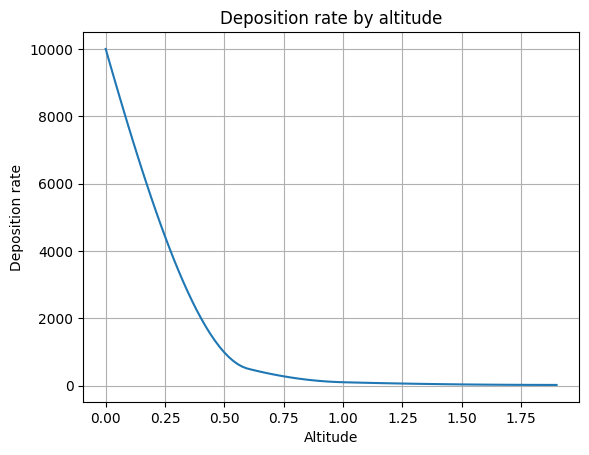

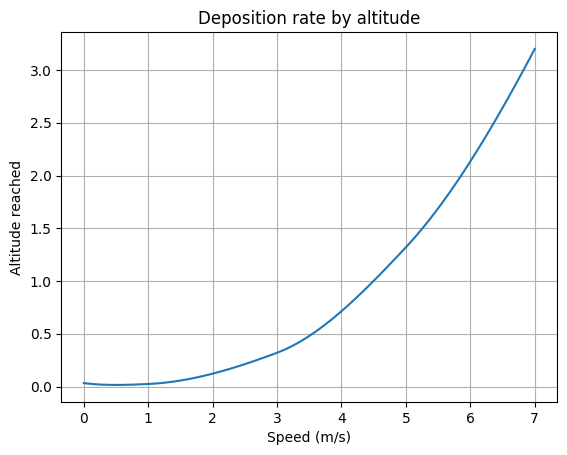

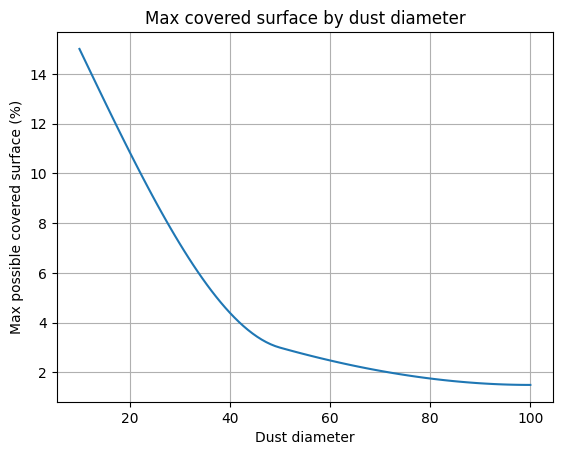

Time Passed:  0.0  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  0.0 %

Time Passed:  3.1709791983764586e-06  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  2.703130086887959e-05 %

Time Passed:  6.341958396752917e-06  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  5.406260173775918e-05 %

Time Passed:  9.512937595129377e-06  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  8.109390260663877e-05 %

Time Passed:  1.2683916793505835e-05  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  0.00010812520347551836 %

Time Passed:  1.5854895991882292e-05  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.983641680394

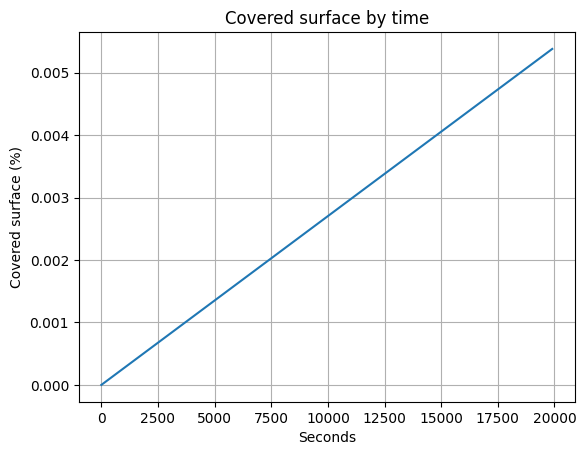

In [11]:
# TESTING WITH INPUT TIME
dust_model = LunarDust()
dust_model.reset_accumulation()

i=0
coverage_points = []
time_points = []
while i < 200:
    
    
    dust_model.update(i*100, panel_structure)
    coverage_points.append(dust_model.coverage * 100)
    time_points.append(i*100)
    i+=1
print(coverage_points)
plt.figure()
plt.plot(time_points, coverage_points)
plt.grid(True)
plt.xlabel("Seconds")
plt.ylabel("Covered surface (%)")
plt.title("Covered surface by time")
plt.show()

DUST COVERAGE LIMITED BY DUST SIZE
Max surface coverage for  4e-05  m dust:  0.10867968750000001


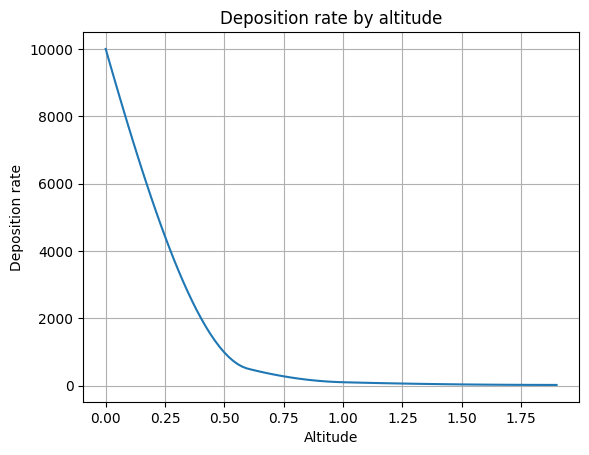

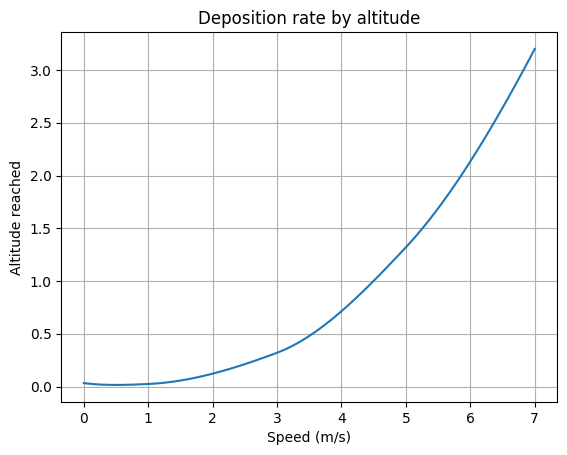

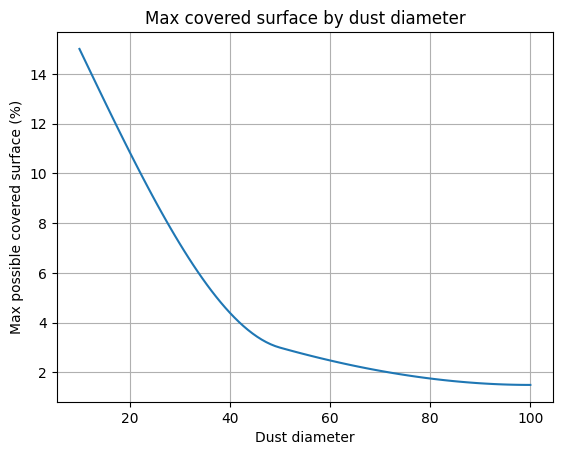

Time Passed:  1.5960596130904754e-07  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  1.3605755480264803e-06 %

Time Passed:  3.181549294968431e-07  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  2.71214066196007e-06 %

Time Passed:  4.767038976846387e-07  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  4.0637057758936605e-06 %

Time Passed:  6.352528658724343e-07  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  5.41527088982725e-06 %

Time Passed:  7.938018340602299e-07  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  6.76683600376084e-06 %

Time Passed:  9.523508022480255e-07  years
Altitude:  0.699999988079071  m
Taux 

KeyboardInterrupt: 

Time Passed:  4.123330166003937e-06  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  3.5149703396366216e-05 %

Time Passed:  4.281879134191733e-06  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  3.6501268510299805e-05 %

Time Passed:  4.440428102379529e-06  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  3.7852833624233394e-05 %

Time Passed:  4.5989770705673244e-06  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  3.920439873816698e-05 %

Time Passed:  4.75752603875512e-06  years
Altitude:  0.699999988079071  m
Taux de deposition:  340.9836416803948  micrograms/cm^2*y
Covered surface by dust:  4.055596385210057e-05 %

Time Passed:  4.916075006942916e-06  years
Altitude:  0.699999988079071  m
Ta

In [ ]:
# TESTING WITH SIMULATION TIME

import omni.timeline

timeline = omni.timeline.get_timeline_interface()
timeline.play()

dust_model = LunarDust()
dust_model.reset_accumulation()

j=0
last_lunar_dust_call = timeline.get_current_time()
while j<1000000:
    previous_time = timeline.get_current_time()
    #print(previous_time)


    if previous_time - last_lunar_dust_call > 5:
        dust_model.update(previous_time, panel_structure)
        last_lunar_dust_call = previous_time

    current_time = timeline.get_current_time()
    simulation_app.update()

    j+=1

In [ ]:
# TEST WITH SOLAR PANELS (WORK IN PROGRESS)

import omni.isaac.core.utils.mesh as mesh_utils 

panel_prim_path = prim_path + "/Panel"
panel = Panel(panel_prim_path)
i=0
while i < 20:
    
    delta_t = 86400*365/2
    panel.update(stage, delta_t)
    coverage_points.append(dust_model.coverage)
    time_points.append(i*delta_t)
    i+=1